# Homework 2

### Due Date: Wednesday, March 24

### Policy Gradient

In this assignment, we will implement vanilla policy gradient algorithm (REINFORCE) covered in the lecture. You will work on i) a function approximator, ii) computing action, iii) collecting samples, iV) training the agent, V) plotting the resutls. 


***Complete the missing operations and test your implemented algorithm on the Gym environment.***

***Software requirements:***
- Python >= 3.6
- Tensorflow version <= 1.15.3 (1.X version)
- OpenAI Gym

- Training the agent (policy) can take long time. It is recomended to start solving the problems earlier.

- Save any plots you generated in this notebook. The grade will be given based on the plots you showed.



Make sure the packages you installed meet the requirements.

In [1]:
import tensorflow as tf
tf.__version__

'1.15.3'

In [2]:
import gym
gym.__version__


'0.17.3'

## 1.1 Tensorflow Implementation

We will be implementing policy gradient algorithm using Tensorflow 1.X., which simply updates the parameters of policy from obtaining gradient estimates. The core of policy gradient is to design a function approximator, computing actions, collecting samples, and training the policy. In the below cell, you are encouraged to fill in the components that are missing. ***Your tasks*** are 

1. Complete the 'create_model' method to output the mean value for diagonal Guassian policy. Covariance is already defined in the model, so focus on creating neural network model.

2. Complete the 'action_op' method to calculate and return the actions for diagonal Gaussian policy. The applied action should be $\pi(s) = \pi_{\text{mean}}(s) + exp(logstd) * \mathcal{N}(0,1)$

***Hints***:
- Some useful tensorflow classes and methods include: 'tf.exp', 'tf.random_normal'



In [3]:
import tensorflow as tf
import numpy as np
import os
import ipdb


class PolicyOpt(object):

    def __init__(self, env, linear=False, stochastic=True, hidden_size=32, nonlinearity=tf.nn.relu):
        """Instantiate the policy iteration class.

        This initializes the policy optimization with a set of trainable 
        parameters, and creates a tensorflow session.

        Attributes
        ----------
        env : gym.Env
            the environment that the policy will be trained on
        linear : bool, optional
            specifies whether to use a linear or neural network 
            policy, defaults to False (i.e. Fully-Connected-Neural-Network)
        stochastic : bool, optional
            specifies whether to use a stochastic or deterministic 
            policy, defaults to True
        hidden_size : list of int, optional
            list of hidden layers, with each value corresponding 
            to the number of nodes in that layer 
        nonlinearity : tf.nn.*
            activation nonlinearity
        """
        
        # clear computation graph
        tf.reset_default_graph()
        
        # set a random seed
        tf.set_random_seed(1234)
        
        # start a tensorflow session
        self.sess = tf.Session()
        
        # environment to train on
        self.env = env
        
        # number of elements in the action space
        self.ac_dim = env.action_space.shape[0]
        
        # number of elements in the observation space
        self.obs_dim = env.observation_space.shape[0]
    
        # actions placeholder
        self.a_t_ph = tf.placeholder(dtype=tf.float32, 
                                  shape=[None, self.ac_dim])
        # state placeholder
        self.s_t_ph = tf.placeholder(dtype=tf.float32, 
                                     shape=[None, self.obs_dim])
        # expected reward placeholder
        self.rew_ph = tf.placeholder(dtype=tf.float32, 
                                     shape=[None])

        # specifies whether the policy is stochastic
        self.stochastic = stochastic

        # policy that the agent executes during training/testing
        self.policy = self.create_model(
            args={
                "num_actions": self.ac_dim,
                "hidden_size": hidden_size,
                "linear": linear,
                "nonlinearity": nonlinearity,
                "stochastic": stochastic,
                "scope": "policy",
            }
        )
        
        # define symbolic action
        self.symbolic_action = self.action_op()

        # initialize all variables
        self.sess.run(tf.global_variables_initializer())

        # create saver to save model variables
        self.saver = tf.train.Saver()

    def create_model(self, args):
        """Create a model for your policy or other components.

        Parameters
        ----------
        args : dict
            model-specific arguments, with keys:
              - "stochastic": True by default
              - "hidden_size": Number of neurons in hidden layer
              - "num_actions" number of output actions
              - "scope": scope of the model

        Returns
        -------
        tf.Variable
            mean actions of the policy
        tf.Variable 
            logstd of the policy actions
        """

#################### Build Your Neural Network Here! ####################        
        # The tutorial approach was not converging so I changed it up to condense the layer generation into
        # single calls to layers.dense instead of tf.mult
        # I also found that relu performed better when designing the network using 3 dense layers
        # When using tanh, the network was more proned to revert back once hitting a low point
        # Example: it would hit around -900 at iteration 100, but instead of progressing to decrease the reward
        # the value would sky rocket back to well past -1600, where as the relu activation allowed the model to continue improving
        
        # Found this resource to change my model setup steps: https://www.oreilly.com/content/building-deep-learning-neural-networks-using-tensorflow-layers/
        
        # First layer using input self.s_t_ph
        layer_1 = tf.layers.dense(inputs = self.s_t_ph, units = args["hidden_size"], activation=tf.nn.relu)
        # Second layer using the layer_1 as the input, I kept the number of units to the same as the first
        layer_2 = tf.layers.dense(inputs = layer_1, units = args["hidden_size"], activation=tf.nn.relu)
        # Third and final layer uses layer_2 as the input and has the number of output units specified by the number of actions
        output_mean = tf.layers.dense(inputs = layer_2, units = args["num_actions"])


        if args["stochastic"]:
            output_logstd =  tf.get_variable(name="action_logstd",shape=[self.ac_dim],trainable=True)
        else:
            output_logstd = None
            
        return output_mean, output_logstd
    
    def action_op(self):
        """
        Create a symbolic expression that will be used to compute actions from observations.

        When the policy is stochastic, the action follows 

            a_t = output_mean + exp(output_logstd) * z; z ~ N(0,1)
        """
        if self.stochastic:
            output_mean, output_logstd = self.policy

            #################### Implement a stochastic policy here ####################        
            # Implement a stochastic version of computing actions.       #
            #                                                            #
            # The action in a stochastic policy represented by           #
            # a diagonal Gaussian distribution with mean "M" and log     #
            # standard deviation "logstd" is computed as follows:        #
            #                                                            #
            #     a = M + exp(logstd) * z                                #
            #                                                            #
            # where z is a random normal value, i.e. z ~ N(0,1)          #
            #                                                            #
            # In order to generate numbers from a normal distribution,   #
            # use the `tf.random_normal` function.                       #
            ########################################################################### 
            symbolic_action = output_mean + tf.multiply(tf.math.exp(output_logstd),tf.random_normal([1]))
        else:
            symbolic_action, _ = self.policy
        
        return symbolic_action

    def compute_action(self, obs):
        """Returns a list of actions for a given observation.

        Parameters
        ----------
        obs : np.ndarray
            observations

        Returns
        -------
        np.ndarray
            actions by the policy for a given observation
        """
        return self.sess.run(self.symbolic_action,feed_dict={self.s_t_ph: obs})

    def rollout(self, s_mean=None, s_std=None):
        """Collect samples from one rollout of the policy.

        Returns
        -------
        dict
            dictionary containing trajectory information for the rollout,
            specifically containing keys for "state", "action", "next_state", "reward", and "done"
        """
        states = []
        next_states = []
        actions = []
        rewards = []
        dones = []

        # start a new rollout by re-setting the environment and collecting the initial state
        state =  self.env.reset()

        steps = 0
        while True:
            steps += 1

            # compute the action given the state
            if s_mean is not None and s_std is not None:
                action = self.compute_action([(state - s_mean) / s_std])
            else:
                action = self.compute_action([state])
            action = action[0]

            # advance the environment once and collect the next state, reward, done, and info parameters from the environment
            next_state, reward, done, info =  self.env.step(action)

            # add to the samples list
            states.append(state)
            actions.append(action)
            next_states.append(next_state)
            rewards.append(reward)
            dones.append(done)

            state = next_state

            # if the environment returns a True for the done parameter,
            # end the rollout before the time horizon is met
            if done or steps > env._max_episode_steps:
                break

        # create the output trajectory
        trajectory = {"state": np.array(states, dtype=np.float32),
                      "reward": np.array(rewards, dtype=np.float32),
                      "action": np.array(actions, dtype=np.float32),
                      "next_state": np.array(next_states, dtype=np.float32),
                      "done": np.array(dones, dtype=np.float32)}

        return trajectory

    def train(self, args):
        """Abstract training method.

        This method will be filled in by algorithm-specific
        training operations in subsequent problems.

        Parameters
        ----------
        args : dict
            algorithm-specific hyperparameters
        """
        raise NotImplementedError



## 1.2 Tensorflow Interpretation

In order to test your implementation of the **stochastic policy**, run the below cell. The task is to interpret the code you implemented in previous section. If you implement correctly, you can see the value_1 and value_2.

***Question: How do you interpret value_1 and value_2 below cell?***


In [4]:
import gym
TEST_ENV = gym.make("Pendulum-v0")

alg = PolicyOpt(TEST_ENV, linear=False)
input_1 = [[0, 1, 2]]
value_1 = alg.sess.run(alg.policy[0], feed_dict={alg.s_t_ph: input_1})
value_2 = alg.compute_action(input_1)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


In [5]:
value_1


array([[0.18702136]], dtype=float32)

Answer: value_1 is the output from compute_action but uses just the output_mean to compute the next action without using Diagonal Gaussian Policy, so it is the action the model 

In [6]:
value_2

array([[-0.05820368]], dtype=float32)

Answer: value_2 is the output from compute_action but uses the symbolic action output which uses Diagonal Gaussian Policy

## 1.3 Implement Policy Gradient

In this section, we will implement REINFORCE algorithm presented in the lecture. As a review, the objective is optimize the parameters $\theta$ of some policy $\pi_\theta$ so that the expected return

\begin{equation}
J(\theta) = \mathbb{E} \bigg\{ \sum_{t=0}^T \gamma^t r(s_{t},a_{t}) \bigg\}
\end{equation}

is optimized. In this algorithm, this is done by calculating the gradient $\nabla_\theta J$ and applying a gradient descent method to find a better policy.

\begin{equation}
\theta ' = \theta + \alpha \nabla_\theta J(\theta)
\end{equation}

In the lecture, we derive how we compute $\nabla_{\theta} J(\theta)$. We can rewrite our policy gradient as:

\begin{equation}
\nabla_\theta J (\theta) \approx \frac{1}{N} \sum_{i=0}^{N} \bigg( \sum_{t=0}^{T} \nabla_\theta \log \pi_\theta (a_{it} | s_{it}) \bigg) \bigg( \sum_{t=0}^T \gamma^{t}r_i(t) \bigg)
\end{equation}

Finally, taking into account the causality principle discussed in class, we are able to simplifiy the gradient estimate such as:

\begin{equation}
\nabla_\theta J (\theta) \approx \frac{1}{N} \sum_{i=0}^{N} \sum_{t=0}^{T} \nabla_\theta \log \pi_\theta (a_{it} | s_{it}) \sum_{t'=t}^T \gamma^{t'-t}r_i(t')
\end{equation}

You will be implementing final expression in this assignment!



The process of REINFOCE algorithm follows:

1. Collect samples from current policy $\pi_\theta(s)$ by executing rollouts of the environment.
2. Calculate an estimate for the expected return at state $s_t$. 
3. Compute the log-likelihood of each action that was performed by the policy at every given step.
4. Estimate the gradient and update the parameters of policy using gradient-based technique.
5. Repeat steps 1-4 for a number of training iterations.

***Your task*** is to fill out the skeleton code for REINFORCE algorithm,

1. Complete the 'log_likelihoods' method to compute gradient of policy, $\nabla_{\theta}\pi_{\theta}$ for diagonal Guassian policy. 

2. Complete the 'compute_expected_return' method to calculate the reward-to-go, $\sum_{t^{\prime}=t}^{T}$. 



In [7]:
import tensorflow as tf
import numpy as np
import time
import tensorflow_probability as tfp

class REINFORCE(PolicyOpt):

    def train(self, num_iterations=1000, steps_per_iteration=1000, learning_rate=int(1e-4), gamma=0.95, 
              **kwargs):
        """Perform the REINFORE training operation.

        Parameters
        ----------
        num_iterations : int
            number of training iterations
        steps_per_iteration : int
            number of individual samples collected every training iteration
        learning_rate : float
            optimizer learning rate
        gamma : float
            discount rate
        kwargs : dict
            additional arguments

        Returns
        -------
        list of float
            average return per iteration
        """
        # set the discount as an attribute
        self.gamma = gamma
        
        # set the learning rate as an attribute
        self.learning_rate = learning_rate

        # create a symbolic expression to compute the log-likelihoods 
        log_likelihoods = self.log_likelihoods() #(?,)
        #print(log_likelihoods.shape)

        # create a symbolic expression for updating the parameters of your policy
        self.opt, self.opt_baseline = self.define_updates(log_likelihoods)
        
        # initialize all variables
        self.sess.run(tf.global_variables_initializer())


        # average return per training iteration
        ret_per_iteration = []
        
        samples = []
        for i in range(num_iterations):
            
            # collect samples from the current policy
            samples.clear()
            steps_so_far = 0
            while steps_so_far < steps_per_iteration:
                new_samples = self.rollout()
                steps_so_far += new_samples["action"].shape[0]
                samples.append(new_samples) # 15000
            #print(len(samples))
            # compute the expected returns
            v_s = self.compute_expected_return(samples) #(15000,0)
            # compute and apply the gradients
            self.call_updates(log_likelihoods, samples, v_s, **kwargs)

            # compute the average cumulative return per iteration
            average_rew = np.mean([sum(s["reward"]) for s in samples])

            # display iteration statistics
            print("Iteration {} return: {}".format(i, average_rew))

            ret_per_iteration.append(average_rew)

        return ret_per_iteration

    def log_likelihoods(self):
        """Create a tensorflow operation that computes the log-likelihood 
        of each performed action.
        """
        
        output_mean, output_logstd = self.policy

        ##############################################################
        # Create a tf operation to compute the log-likelihood of     #
        # each action that was performed by the policy               #
        #                                                            #
        # The log likelihood in the continuous case where the policy #
        # is expressed by a multivariate gaussian can be computing   #
        # using the tensorflow object:                               #
        #                                                            #
        #    p = tfp.distributions.MultivariateNormalDiag(           #
        #        loc=...,                                            #
        #        scale_diag=...,                                     #
        #    )                                                       #
        #                                                            #
        # This method takes as input a mean (loc) and standard       #
        # deviation (scale_diag), and then can be used to compute    #
        # the log-likelihood of a variable as follows:               #
        #                                                            #
        #    log_likelihoods = p.log_prob(...)                       #
        #                                                            #
        # For this operation, you will want to use placeholders      #
        # created in the __init__ method of problem 1.               #
        ##############################################################
        
        p = tfp.distributions.MultivariateNormalDiag(loc=output_mean,scale_diag=(output_logstd))

        log_likelihoods = p.log_prob(self.a_t_ph)
        
        return log_likelihoods

    def compute_expected_return(self, samples):
        """Compute the expected return from a given starting state.
        This is done by using the reward-to-go method.

        Parameters
        ----------
        rewards : list of list of float
            a list of N trajectories, with each trajectory contain T 
            returns values (one for each step in the trajectory)

        Returns
        -------
        list of float, or np.ndarray
            expected returns for each step in each trajectory
        """
        rewards = [s["reward"] for s in samples]
        ##############################################################
        # Estimate the expected return from any given starting state #
        # using the reward-to-go method.                             #
        #                                                            #
        # Using this method, the reward is estimated at every step   #
        # of the trajectory as follows:                              #
        #                                                            #
        #   r = sum_{t'=t}^T gamma^(t'-t) * r_{t'}                   #
        #                                                            #
        # where T is the time horizon at t is the index of the       #
        # current reward in the trajectory. For example, for a given #
        # set of rewards r = [1,1,1,1] and discount rate gamma = 1,  #
        # the expected reward-to-go would be:                        #
        #                                                            #
        #   v_s = [4, 3, 2, 1]                                       #
        #                                                            #
        # You will be able to test this in one of the cells below!   #
        ##############################################################
        v_s = []
        d_sum = 0
        # go through each list of rewards
        for reward in rewards:
            # go through each reward in a list of rewards
            for v in range(len(reward)):
                # this will multiply the sum of the rewards starting at position 'v'
                # to gamme to the power of the number of rewards minus the position
                d_sum = (sum(reward[v:])*pow(self.gamma,(len(rewards)-v)))
                v_s.append(d_sum)
        return v_s

    def define_updates(self, log_likelihoods):
        """Create a tensorflow operation to update the parameters of 
        your policy.

        Parameters
        ----------
        log_likelihoods : tf.Operation
            the symbolic expression you created to estimate the log 
            likelihood of a set of actions

        Returns
        -------
        tf.Operation
            a tensorflow operation for computing and applying the 
            gradients to the parameters of the policy
        None
            the second component is used in problem 2.b, please ignore 
            for this problem
        """

        loss = - tf.reduce_mean(tf.multiply(log_likelihoods, self.rew_ph))
        opt = tf.train.AdamOptimizer(self.learning_rate).minimize(loss)

        return opt, None

    def call_updates(self, log_likelihoods, samples, v_s, **kwargs):
        """Apply the gradient update methods in a tensorflow session.

        Parameters
        ----------
        log_likelihoods: tf.Operation
            the symbolic expression you created to estimate the log 
            likelihood of a set of actions
        samples : list of dict
            a list of N trajectories, with each trajectory containing 
            a dictionary of trajectory data (see self.rollout)
        v_s : list of float, or np.ndarray
            the estimated expected returns from your
            `comput_expected_return` function 
        kwargs : dict
            additional arguments (used in question 3)
        """
        # concatenate the states (15000,3)
        states = np.concatenate([s["state"] for s in samples])
        # concatenate the actions (15000,)
        actions = np.concatenate([s["action"] for s in samples])
        # execute the optimization step
        self.sess.run(self.opt, feed_dict={self.s_t_ph: states, self.a_t_ph: actions, self.rew_ph: v_s})

Check your 'log_likelihoods' method by running below cell:

In [8]:
alg = REINFORCE(TEST_ENV, stochastic=True)

log_likelihoods = alg.log_likelihoods()

# collect a sample output for a given input state
input_s = [[0, 0, 0], [0, 1, 2], [1, 2, 3]]
input_a = [[0], [1], [2]]

# Check
computed = alg.sess.run(log_likelihoods, feed_dict={alg.a_t_ph: input_a, alg.s_t_ph: input_s})

Test your 'compute_expected_return' by running below cell:

In [9]:
# 1. Test the non-normalized case
alg = REINFORCE(TEST_ENV, stochastic=True)
alg.gamma = 1.0
    
input_1 = [{"reward": [1, 1, 1, 1]},
           {"reward": [1, 1, 1, 1]}]
vs_1 = alg.compute_expected_return(samples=input_1)
ans_1 = np.array([4, 3, 2, 1, 4, 3, 2, 1])
print(vs_1)
if np.linalg.norm(vs_1 - ans_1) < 1e-3:
    print('Great job!')
else:
    print('Check your implementation (compute_expected_return)')

    

[4.0, 3.0, 2.0, 1.0, 4.0, 3.0, 2.0, 1.0]
Great job!


## 1.4 Testing your algorithm

When you are ready, test your policy gradient algorithms on the *Pendulum-v0* environment in the cell below. *Pendulum-v0* environment is similar to *off-shore wind power*, the goal here is to maintain the Pendulum is upright using control input. The best policy should get around -200 scores. ***Your task*** is to run your REINFORCE algorithm and plot the result!


In [10]:
# set this number as 1 for testing your algorithm, and 3 for plotting
NUM_TRIALS = 3

# ===========================================================================
# Do not modify below line
# ===========================================================================

# we will test the algorithms on the Pendulum-v0 gym environment
import gym
env = gym.make("Pendulum-v0")

# train on the REINFORCE algorithm
import numpy as np
r = []

for i in range(NUM_TRIALS):
    alg = None
    print("\n==== Training Run {} ====".format(i))
    alg = REINFORCE(env, stochastic=True)
    res = alg.train(learning_rate=0.005, gamma=0.95, num_iterations=500, steps_per_iteration=15000)
    r.append(np.array(res))

# save results
np.savetxt("InvertedPendulum_results.csv", np.array(r), delimiter=",")


==== Training Run 0 ====
Iteration 0 return: -1175.625832608665
Iteration 1 return: -1200.4786154612962
Iteration 2 return: -1199.8553744800172
Iteration 3 return: -1145.6039474289119
Iteration 4 return: -1136.41135873707
Iteration 5 return: -1136.0377037925305
Iteration 6 return: -1179.1588341959007
Iteration 7 return: -1106.8291349286167
Iteration 8 return: -1158.4633137412493
Iteration 9 return: -1148.0341085803416
Iteration 10 return: -1118.2170844218074
Iteration 11 return: -1138.4369880682727
Iteration 12 return: -1105.846150182141
Iteration 13 return: -1120.2856833035746
Iteration 14 return: -1150.3565244603126
Iteration 15 return: -1163.2900493148343
Iteration 16 return: -1153.9903987480031
Iteration 17 return: -1221.07132838826
Iteration 18 return: -1209.079430268146
Iteration 19 return: -1188.5009539074892
Iteration 20 return: -1171.4254336728343
Iteration 21 return: -1219.099577089455
Iteration 22 return: -1173.0620426920088
Iteration 23 return: -1239.9416132533395
Iteratio

Iteration 200 return: -355.6173555083762
Iteration 201 return: -318.3805704860621
Iteration 202 return: -322.2772764858328
Iteration 203 return: -296.7954091594423
Iteration 204 return: -290.81057335691276
Iteration 205 return: -314.872931639116
Iteration 206 return: -305.5308040881742
Iteration 207 return: -329.0000208732266
Iteration 208 return: -343.45372782834846
Iteration 209 return: -323.7890573106431
Iteration 210 return: -287.20553645534005
Iteration 211 return: -373.9301890544906
Iteration 212 return: -331.73257060921463
Iteration 213 return: -336.2125863586976
Iteration 214 return: -293.0703208156369
Iteration 215 return: -283.0351493957117
Iteration 216 return: -329.1027174539884
Iteration 217 return: -290.84362275772077
Iteration 218 return: -323.84272008704187
Iteration 219 return: -286.2722089306795
Iteration 220 return: -274.21005936563324
Iteration 221 return: -323.7033067990217
Iteration 222 return: -328.3525065337071
Iteration 223 return: -314.43026300515146
Iteration

Iteration 398 return: -256.87800261375156
Iteration 399 return: -265.01965691550754
Iteration 400 return: -247.13739322134313
Iteration 401 return: -305.64277114496605
Iteration 402 return: -256.9222908922286
Iteration 403 return: -263.1923223620953
Iteration 404 return: -250.7263649889752
Iteration 405 return: -278.8534484669017
Iteration 406 return: -267.66182103247917
Iteration 407 return: -233.5267126121731
Iteration 408 return: -292.44936353716264
Iteration 409 return: -231.7153432912035
Iteration 410 return: -255.16337899772586
Iteration 411 return: -263.985836693656
Iteration 412 return: -244.37375078467224
Iteration 413 return: -270.6186629776078
Iteration 414 return: -273.58069449173985
Iteration 415 return: -231.35213409751591
Iteration 416 return: -261.6109137995658
Iteration 417 return: -283.55087248607924
Iteration 418 return: -282.2693805263265
Iteration 419 return: -261.74639912751957
Iteration 420 return: -260.73290537483746
Iteration 421 return: -237.07584368671576
Ite

Iteration 98 return: -853.4226011247366
Iteration 99 return: -868.259091434617
Iteration 100 return: -872.2840087679712
Iteration 101 return: -860.1642175028877
Iteration 102 return: -881.1402444078121
Iteration 103 return: -885.5848513587192
Iteration 104 return: -866.3451561575391
Iteration 105 return: -867.6821366964932
Iteration 106 return: -844.1681238449459
Iteration 107 return: -868.4149503074927
Iteration 108 return: -823.7175138486145
Iteration 109 return: -814.9815124821943
Iteration 110 return: -813.7687952790766
Iteration 111 return: -797.9521529487552
Iteration 112 return: -835.2519182964911
Iteration 113 return: -802.5400420980808
Iteration 114 return: -800.203724423229
Iteration 115 return: -793.803686820385
Iteration 116 return: -758.9586373551756
Iteration 117 return: -731.2091304524045
Iteration 118 return: -723.782278049315
Iteration 119 return: -705.7805639161488
Iteration 120 return: -713.5635576691344
Iteration 121 return: -665.5582783604724
Iteration 122 return: 

Iteration 297 return: -243.51641709624616
Iteration 298 return: -261.95290376600076
Iteration 299 return: -285.8388639953762
Iteration 300 return: -260.0397970064868
Iteration 301 return: -298.6844279071902
Iteration 302 return: -256.738722823289
Iteration 303 return: -264.5511808846627
Iteration 304 return: -263.6930019498419
Iteration 305 return: -320.4193545091114
Iteration 306 return: -258.84212802877914
Iteration 307 return: -219.78238221229603
Iteration 308 return: -267.17327629014346
Iteration 309 return: -233.5481178750771
Iteration 310 return: -229.78357909775804
Iteration 311 return: -272.27540847745377
Iteration 312 return: -264.5639322889998
Iteration 313 return: -284.90378667253094
Iteration 314 return: -242.82897070293131
Iteration 315 return: -268.094540835494
Iteration 316 return: -233.02344752366528
Iteration 317 return: -281.93729895851453
Iteration 318 return: -255.86199058995894
Iteration 319 return: -237.64090700347117
Iteration 320 return: -254.97190775013732
Iter

Iteration 495 return: -240.57498359011268
Iteration 496 return: -250.75910906669154
Iteration 497 return: -219.74215030865616
Iteration 498 return: -283.20091168581837
Iteration 499 return: -274.35877718203653

==== Training Run 2 ====
Iteration 0 return: -1201.553665083057
Iteration 1 return: -1191.6985930779274
Iteration 2 return: -1184.4644496424014
Iteration 3 return: -1158.2224763288955
Iteration 4 return: -1145.1510208033505
Iteration 5 return: -1125.3669228772787
Iteration 6 return: -1140.2413670587882
Iteration 7 return: -1146.275837245842
Iteration 8 return: -1108.0808933927678
Iteration 9 return: -1151.611048987226
Iteration 10 return: -1151.6150743704661
Iteration 11 return: -1161.6140714130054
Iteration 12 return: -1097.4799458362363
Iteration 13 return: -1117.097044608593
Iteration 14 return: -1135.847246658964
Iteration 15 return: -1165.760124141428
Iteration 16 return: -1119.9466302924325
Iteration 17 return: -1132.2844932604798
Iteration 18 return: -1099.6967038505059
I

Iteration 196 return: -275.0014306670922
Iteration 197 return: -277.3582607347263
Iteration 198 return: -286.7886296624884
Iteration 199 return: -294.5273116935791
Iteration 200 return: -332.7096420666823
Iteration 201 return: -298.42790679015326
Iteration 202 return: -272.9745492725401
Iteration 203 return: -278.79143694299506
Iteration 204 return: -311.9232839924042
Iteration 205 return: -260.8356602059079
Iteration 206 return: -282.5320261689123
Iteration 207 return: -335.85048787308114
Iteration 208 return: -277.8228740801622
Iteration 209 return: -290.6415915586997
Iteration 210 return: -240.8322060743888
Iteration 211 return: -264.86320375741576
Iteration 212 return: -285.0743272321708
Iteration 213 return: -288.2844427997232
Iteration 214 return: -295.56769122689883
Iteration 215 return: -280.5155800505259
Iteration 216 return: -264.73348284368495
Iteration 217 return: -318.3597968334518
Iteration 218 return: -320.2871799382441
Iteration 219 return: -280.2151178034452
Iteration 

Iteration 394 return: -254.64670089739369
Iteration 395 return: -276.0605905947869
Iteration 396 return: -265.74601185226555
Iteration 397 return: -264.6795338977145
Iteration 398 return: -258.3059328825354
Iteration 399 return: -252.5020574699022
Iteration 400 return: -244.33992994951987
Iteration 401 return: -250.64541249734495
Iteration 402 return: -249.380066196082
Iteration 403 return: -282.006519307413
Iteration 404 return: -251.97758502875755
Iteration 405 return: -240.462018532866
Iteration 406 return: -271.3453724206085
Iteration 407 return: -241.217460791368
Iteration 408 return: -269.7817365414592
Iteration 409 return: -242.18509236053248
Iteration 410 return: -220.10041195881203
Iteration 411 return: -245.40233743957197
Iteration 412 return: -252.97082978795632
Iteration 413 return: -222.99803752094502
Iteration 414 return: -234.80740702757475
Iteration 415 return: -270.4376967836116
Iteration 416 return: -256.1835932471292
Iteration 417 return: -210.86485994297294
Iteratio

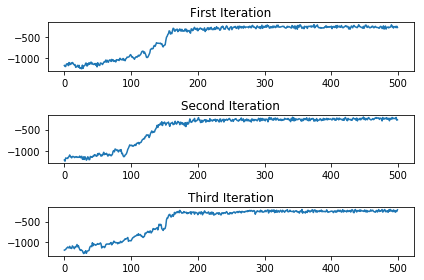

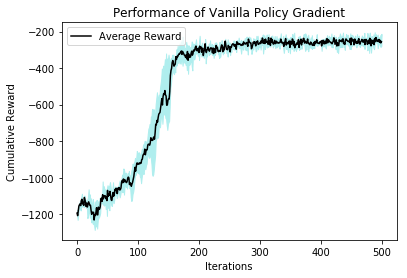

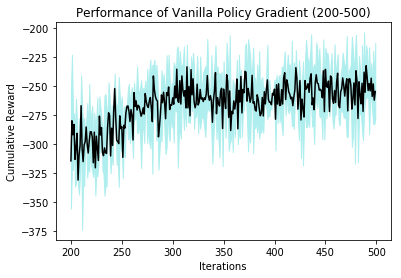

In [6]:
# collect saved results
import numpy as np
import matplotlib.pyplot as plt
r1 = np.genfromtxt("InvertedPendulum_results.csv", delimiter=",")
all_results = [r1]
labels = ["REINFORCE"]
##############################################################
# Plot your Policy Gradient results below
##############################################################

first_iteration = r1[0]
second_iteration = r1[1]
third_iteration = r1[2]
max_value = []
min_value = []
average_value = []
for i in range(0,len(r1[0])):
    average_value.append((first_iteration[i]+second_iteration[i]+third_iteration[i])/3)
    max_value.append(max([first_iteration[i],second_iteration[i],third_iteration[i]]))
    min_value.append(min([first_iteration[i],second_iteration[i],third_iteration[i]]))

fig1, ax1 = plt.subplots(3)

ax1[0].plot(first_iteration)
plt.title("Cumulative Reward vs Iteration for each Iteration")
ax1[0].set_title("First Iteration")
ax1[1].plot(second_iteration)
ax1[1].set_title("Second Iteration")
ax1[2].plot(third_iteration)
ax1[2].set_title("Third Iteration")
fig1.tight_layout()

# Plot the average reward line and shade inbetween the max and min
fig2, ax2 = plt.subplots()
ax2.plot(average_value, label = "Average Reward", color='black')
x = np.arange(0, 500, 1)
ax2.fill_between(x,min_value, max_value, color='paleturquoise')

plt.xlabel('Iterations')
plt.ylabel('Cumulative Reward')
plt.title('Performance of Vanilla Policy Gradient')
# show a legend on the plot
plt.legend()


fig3, ax3 = plt.subplots()
x = np.arange(200, 500, 1)
last_iterations = average_value[200:500]
last_max = max_value[200:500]
last_min = min_value[200:500]
ax3.plot(x,last_iterations, label = "Average Reward", color='black')
ax3.fill_between(x,last_min, last_max, color='paleturquoise')

plt.xlabel('Iterations')
plt.ylabel('Cumulative Reward')
plt.title('Performance of Vanilla Policy Gradient (200-500)')

plt.show()